In [34]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from gfcat_utils import *

In [3]:
import numpy as np
from astropy.io import fits as pyfits
from astropy import wcs as pywcs
from astropy.visualization import simple_norm, ZScaleInterval
import imageio
from matplotlib.colors import LinearSegmentedColormap

In [4]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
tmpdir = "/Users/cm/GFCAT/gfcat/tmp/"

In [6]:
lc = parse_lightcurves("/Users/cm/GFCAT/data/e42907/e42907-nd-30s-photom.csv")
x = np.array([source['xcenter'] for source in lc])
y = np.array([source['ycenter'] for source in lc])
cps = np.array([np.nanmean(source['cps']) for source in lc])
print(lc[0].keys())

dict_keys(['counts', 'edge_flags', 'mask_flags', 'cps', 'cps_err', 'xcenter', 'ycenter', 'ra', 'dec'])

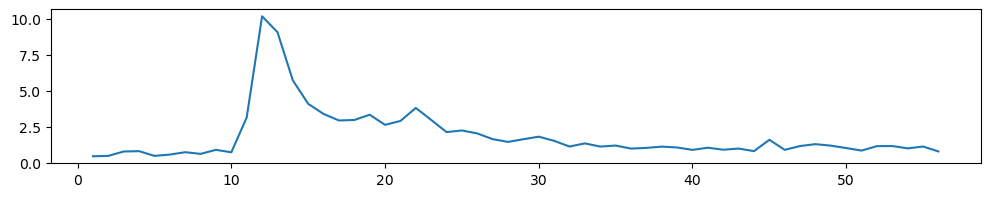

In [7]:
plt.figure(figsize=(12,2))
plt.plot(lc[1128]['cps'])
imgx,imgy = lc[1128]['xcenter'],lc[1128]['ycenter']

In [8]:
#fn = '/Users/cm/GFCAT/data/e42907/e42907-nd-full.fits.gz'
fn = '/Users/cm/github/gphoton_working/test_data/e46635/e46635-nd-30s.fits.gz'
fn = '/Users/cm/github/gphoton_working/test_data/e42907/e42907-nd-30s-rice.fits'
eclipse = fn.split('/')[-1].split('-')[0][1:]
print(f"e{eclipse}")

e42907

In [9]:
movmap,flagmap,edgemap,wcs,tranges,exptimes=read_image(fn,hdunum=1)
movmap[np.where(np.isinf(movmap))]=0 # because it pops out with inf values... IDK
movmap[np.where(movmap<0)]=0
#flagmap[np.where(flagmap==1)]=255
#edgemap[np.where(edgemap==1)]=255

print(np.shape(movmap),np.shape(edgemap),np.shape(flagmap))

(57, 3196, 3186)
(57, 3196, 3186)
(57, 3196, 3186)

In [10]:
cdict = {'red':   ((1,0,0),),
         'green': ((0.0,  1, 0),),
         'blue':  ((0.0,  0.0, 1),)}
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
cm = LinearSegmentedColormap.from_list('red_just_red', colors, N=1)

In [11]:
np.min(ZScaleInterval()(movmap[10])),np.max(flagmap)

(0.0, 1)

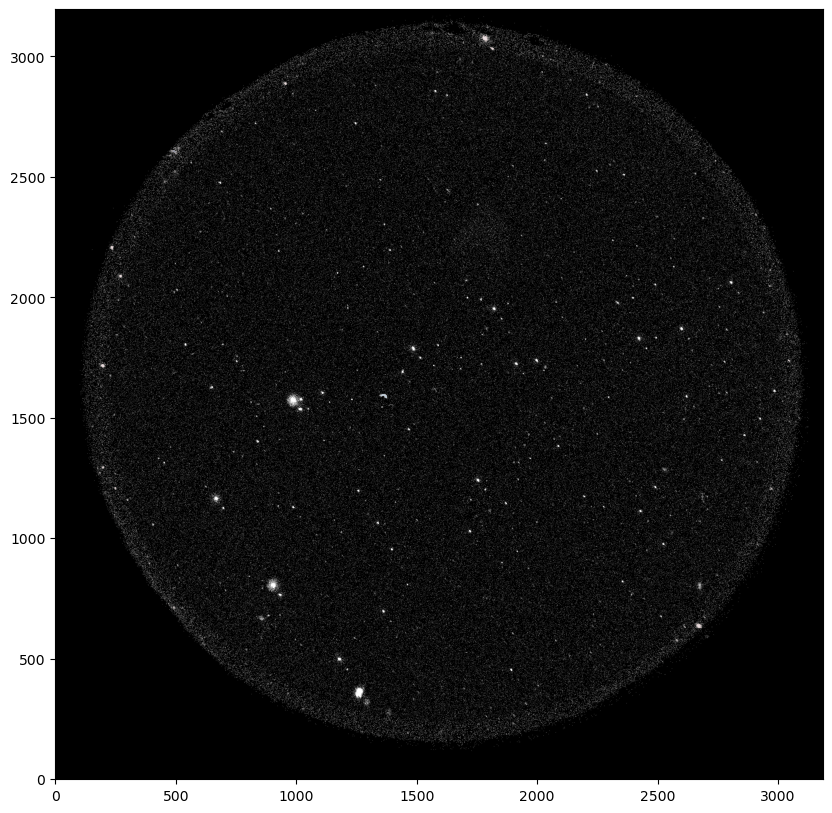

In [25]:
plt.figure(figsize=(10,10))
# M, N, 3 or M, N, 4
opacity = (edgemap[10]+flagmap[10])/2
plt.imshow(edgemap[10],origin="lower",cmap="Reds",alpha=opacity)
plt.imshow(flagmap[10],origin="lower",cmap="Blues",alpha=opacity)
plt.imshow(np.stack([ZScaleInterval()(movmap[10]),
                     ZScaleInterval()(movmap[10]),
                     ZScaleInterval()(movmap[10]),
                     1-opacity],axis=2),origin="lower")

In [13]:
assert len(lc[1128]['cps'])==np.shape(movmap)[0]

In [32]:
if not os.path.exists(f'{tmpdir}/e{eclipse}/'):
    os.makedirs(f'{tmpdir}/e{eclipse}/')

imsz = np.shape(movmap[0])

# crop on the subframe
boxsz = 200
x1, x2, y1, y2 = (max(int(imgy - boxsz),0),
                  min(int(imgy + boxsz),imsz[0]),
                  max(int(imgx - boxsz),0),
                  min(int(imgx + boxsz),imsz[1]))

# crop on the full frame
x1_,x2_,y1_,y2_ = (max(int(imsz[0]/2-imsz[0]/2),0),
                   min(int(imsz[0]/2+imsz[0]/2),imsz[0]),
                   max(int(imsz[1]/2-imsz[0]/2),0),
                   min(int(imsz[1]/2+imsz[0]/2),imsz[1]))


gs = gridspec.GridSpec(nrows=4, ncols=6)#, height_ratios=[1, 1, 2])

# write individual frames of the animated gif
for i,frame in enumerate(movmap): # probably eliminate the first / last frame, which always has lower exposure
    fig = plt.figure(figsize=(12,9));
    fig.tight_layout()
    ax = fig.add_subplot(gs[:3,:3])
    opacity = (edgemap[i]+flagmap[i])/2
    # M, N, 3 or M, N, 4
    ax.imshow(edgemap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Reds",alpha=opacity[x1_:x2_,y1_:y2_])
    ax.imshow(flagmap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Blues",alpha=opacity[x1_:x2_,y1_:y2_])
    ax.imshow(np.stack([ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                         ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                         ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                         1-opacity[x1_:x2_,y1_:y2_]],axis=2),origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    rect = Rectangle((y1-y1_, x1-x1_), 2*boxsz, 2*boxsz, linewidth=1, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

    ax = fig.add_subplot(gs[:3,3:])
    ax.imshow(edgemap[i][x1:x2,y1:y2],origin="lower",cmap="Reds",alpha=opacity[x1:x2,y1:y2])
    ax.imshow(flagmap[i][x1:x2,y1:y2],origin="lower",cmap="Blues",alpha=opacity[x1:x2,y1:y2])
    ax.imshow(np.stack([ZScaleInterval()(frame[x1:x2,y1:y2]),
                         ZScaleInterval()(frame[x1:x2,y1:y2]),
                         ZScaleInterval()(frame[x1:x2,y1:y2]),
                         1-opacity[x1:x2,y1:y2]],axis=2),origin="lower")
    ax.set_xticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(gs[3:,:])
    ax.set_xticks([])
    t = np.arange(len(lc[1128]['cps']))
    cps = lc[1128]['cps']
    ax.scatter(t[i],cps[i],c='y',s=100,marker='o')
    ax.plot(t,cps,'k.-')
    ax.vlines(t[i],min(cps),max(cps))
    #rect = Rectangle((y1-y1_, x1-x1_), 2*boxsz, 2*boxsz, linewidth=1, edgecolor='y', facecolor='none')
    #ax.add_patch(rect)

    plt.savefig(f'{tmpdir}/e{eclipse}/e{eclipse}_movie_{str(i).zfill(2)}.png',dpi=200)
    plt.close()

In [33]:
n_frames = np.shape(movmap)[0]
# write the animated gif
with imageio.get_writer(f'{tmpdir}/e{eclipse}/e{eclipse}.gif', mode='I', fps=4) as writer:
    for i in np.arange(n_frames):
        image = imageio.imread(f'{tmpdir}/e{eclipse}/e{eclipse}_movie_{str(i).zfill(2)}.png')
        writer.append_data(image)